In [6]:
import calendar
import jinja2
import os
import datetime
import pandas as pd
import urllib.request, json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from dateutil.parser import parse

import sympy as sym
from scipy.optimize import curve_fit



latex_jinja_env = jinja2.Environment(
    block_start_string='\BLOCK{',
    block_end_string='}',
    variable_start_string='\VAR{',
    variable_end_string='}',
    comment_start_string='\#{',
    comment_end_string='}',
    line_statement_prefix='%%',
    line_comment_prefix='%#',
    trim_blocks=True,
    autoescape=False,
    loader=jinja2.FileSystemLoader("templates")
)

# Scrapping from URL

In [7]:
def scrap():
    with urllib.request.urlopen("https://www.enforcementtracker.com/data.json?") as url:
        jsondata = json.loads(url.read())
    data_list = []
    list_header = ['Code', 'Country', 'Authority', 'Date', 'Fine', 'Controller', 'Sector', 'Quoted Art.', 'Type',
                   'Summary', 'Link']

    for one_data in jsondata['data']:
        sub_data = []
        for i in range(1, 12):
            try:
                if i == 2:
                    one_data[i] = one_data[i].rsplit("<br />", 1)
                    one_data[i] = one_data[i][1]
                if i == 11:
                    one_data[i] = one_data[i].split("'")
                    one_data[i] = one_data[i][3]
                sub_data.append(one_data[i])
            except:
                continue
        data_list.append(sub_data)
        
    dataFrame = pd.DataFrame(data=data_list, columns=list_header)
    return dataFrame

DATA = scrap()

# Define DYEAR 

In [8]:
global DYEAR
DYEAR = getYearData(DATA)
if(DYEAR.empty & (YEAR == datetime.datetime.now().year) ) :
    print ("there is still no fine for this year. Try a year between 2018 and "+str(YEAR-1))

NameError: name 'getYearData' is not defined

# Recents Fines with Summary

In [9]:
def three_most_recent(data):
    dc = data.sort_values(by=['Date'], ascending=False)
    dc.drop_duplicates()
    three_most_recent = dc.head(3)
    n = min (3,len(DYEAR.index))
    for i in range(1, n+1):
        VARS["new" + str(i) + "_summary"] = str(dc.iloc[i - 1].Summary)
        VARS["new" + str(i) + "_date"] = str(dc.iloc[i - 1].Date)
        VARS["new" + str(i) + "_link"] = str(dc.iloc[i - 1].Link)
        VARS["new" + str(i) + "_fine"] = str(dc.iloc[i - 1].Fine)
        VARS["new" + str(i) + "_country"] = str(dc.iloc[i - 1].Country)
        VARS["new" + str(i) + "_controller"] = str(dc.iloc[i - 1].Controller)

    for i in range(n+1,4):
        VARS["new" + str(i) + "_summary"] = "N/A"
        VARS["new" + str(i) + "_date"] = "N/A"
        VARS["new" + str(i) + "_link"] = "N/A"
        VARS["new" + str(i) + "_fine"] = "N/A"
        VARS["new" + str(i) + "_country"] = "N/A"
        VARS["new" + str(i) + "_controller"] = "N/A"

# Notable Fines

In [10]:
def get_notable_fines():
    df = DYEAR[DYEAR.Fine != 'Unknown']
    largest_fine= 0
    c_min = df.iloc[0].Fine
    c_max = 0
    lowest_fine = int(df.iloc[0].Fine.replace(',', ''))

    for c in df['Fine']:
        fine = int(c.replace(',', ''))
        if largest_fine < fine:
            c_max = c
            largest_fine = fine
        if lowest_fine > fine :
            c_min = c
            lowest_fine = fine

    VARS["largest_fine_summary"] = DYEAR[DYEAR.Fine == c_max].iloc[0].Summary
    VARS["lowest_fine_summary"] = DYEAR[DYEAR.Fine == c_min].iloc[0].Summary
    VARS["largest_fine_controller"] = DYEAR[DYEAR.Fine == c_max].iloc[0].Controller.replace("&", "\\&")
    VARS["lowest_fine_controller"] = DYEAR[DYEAR.Fine == c_min].iloc[0].Controller.replace("&", "\\&")
    VARS["largest_fine"] = largest_fine
    VARS["lowest_fine"] = lowest_fine
    VARS["largest_fine_link"] = DYEAR[DYEAR.Fine == c_max].iloc[0].Link
    VARS["lowest_fine_link"] = DYEAR[DYEAR.Fine == c_min].iloc[0].Link
    VARS["lowest_fine_country"] = DYEAR[DYEAR.Fine == c_min].iloc[0].Country
    VARS["largest_fine_country"] = DYEAR[DYEAR.Fine == c_max].iloc[0].Country

# Accumulation graph with approximation 

In [11]:
def linear_approx(data):
    # General Definition for all date related statistic
    date_list = []
    date_header = ['Year', 'Month', 'Day']
    month = ['', 'Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

    # Parse date into columns
    for d in data['Date']:
        date_list.append(d.split('-'))
    ds = pd.DataFrame(data=date_list, columns=date_header)

    # Get min & max of year & month
    da = ds.sort_values(['Year', 'Month'], na_position='first').dropna().reset_index().drop(columns='index')
    minyear = da['Year'][0]
    minmonth = da['Month'][0]
    maxyear = da['Year'][len(da) - 1]
    maxmonth = da['Month'][len(da) - 1]
    count = []
    c = 0
    xtlist = []
    for y in range(int(minyear), int(maxyear) + 1):
        for m in range(1, 13):
            if (((y == int(minyear)) & (m < int(minmonth))) | ((y == int(maxyear)) & (m > int(maxmonth)))):
                continue
            else:
                xtlist.append(str(y) + "  " + month[m])
                if (m < 10):
                    c = c + len(da[(da['Year'] == str(y)) & (da['Month'] == '0' + str(m))])
                    count.append(c)
                else:
                    c = c + len(da[(da['Year'] == str(y)) & (da['Month'] == str(m))])
                    count.append(c)

    # Prepare data frame for the graph
    dc = pd.DataFrame(data=xtlist, columns=['Year,Month'])
    dc['Count'] = count

    # Plot graph
    dc.plot(figsize=(12, 5), fontsize=10, color='blue', marker='o', legend=True, rot=60, ylim=(0, dc['Count'].max()))


    y = dc['Count'].to_numpy()
    x =  np.arange(len(dc))

    # linear approximation of degree 1
    parametres = np.polyfit(x, y, 1 )

    # parameters of the linear approximation
    a, b = parametres
    print("a = {:8.3f}\nb = {:8.3f}".format(a, b))

    plt.plot(  # droite de regression
        [x[0], x[-1]],  # valeurs de x
        [a * x[0] + b, a * x[-1] + b],  # valeurs de y
        "r-",  # couleur rouge avec un trait continu
        label="regression")  # legende
    
    # Prepare Graph
    plt.xlabel("Year, Month", fontsize='large', fontweight='bold')
    plt.ylabel("Number of cases", fontsize='large', fontweight='bold')
    plt.xticks(range(0, len(xtlist)), xtlist)
    plt.ylim(0,dc['Count'][len(dc)-1]+100)
    plt.title("Number of cases per month", fontsize='xx-large', fontweight='bold')

    # To specify the number of ticks on both or any single axes
    plt.locator_params(axis='x', nbins=(int(maxyear) - int(minyear) + 1) * 6)
    plt.tight_layout()
    plt.grid()
    # plt.show()
    plt.savefig("../report_build/graphs/" + "acc_nb_cases" + "_graph.jpeg")


    return parametres

a =   16.399
b =  -86.730


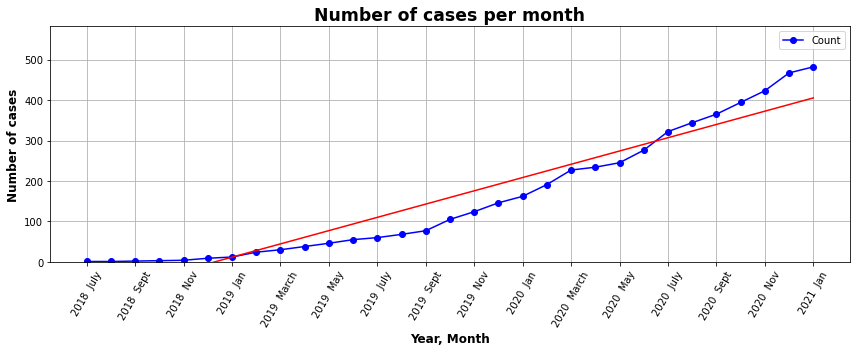

In [12]:
linear_approx(DATA);

# Counter

In [13]:
def gdpr_counter(data, fig_name):
    counter_list = []
    nb_of_cases = data.Code.count()

    amt_fine = 0
    for c in data['Fine']:
        if (c == "Unknown"):
            c = "0"

        amt_fine += int(c.replace(',', ''))

    str_amt = str(amt_fine)
    result = ''

    while str_amt:
        result += str_amt[:3]
        if len(str_amt) > 3:
            result += ' '
        str_amt = str_amt[3:]
    result = result + "€"


    counter_list = [nb_of_cases, result]

    VARS[fig_name+"_nb_cases"] = nb_of_cases
    VARS[fig_name + "_sum"] = result


    dc = pd.DataFrame(counter_list, index=["Nb of cases", "Total Amount of Fine"])

    # Plot a background
    plt.figure(linewidth=1,
               #           edgecolor='steelblue',
               #           facecolor='skyblue',
               tight_layout={'pad': 0.5},
               figsize=(8, 2)
               )

    # Plot table
    the_table = plt.table(dc.values, rowLabels=dc.index, loc='center', rowLoc='center', cellLoc='center',
                          edges='horizontal')
    the_table.set_fontsize(25)
    the_table.scale(1, 5)

    # Hide axes & Prepare graph
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.box(on=None)

    plt.savefig("../report_build/graphs/" + fig_name+".jpeg")

In [14]:
    gdpr_counter(DATA, "counter")

NameError: name 'VARS' is not defined

# Countries Related

In [15]:
def top10countries(data, fig_name):
    # Finding Top 10 Countries
    grouped_data = pd.DataFrame(data['Country'].value_counts())
    grouped_data = grouped_data.reset_index()
    grouped_data.columns = ['Country', 'Counts']
    top10_countries = grouped_data.head(10)


    # Exporting the Top 10 Countries Plot
    top10_countries.plot(figsize=(10, 6), x='Country', y='Counts', kind='bar', rot=0)
    plt.xlabel('Countries', fontsize='large', fontweight='bold')
    plt.ylabel('Number of fines related to Countries', fontsize='large', fontweight='bold')
    plt.xticks(fontsize='medium')
    plt.tight_layout();
    plt.savefig("../report_build/graphs/" + fig_name + ".jpeg")

    # Finding Top 10 Country / Sum of fines
    country_sum_fine = []
    for country in grouped_data['Country']:
        ex = data.loc[data['Country'] == country, :]
        ex = ex.reset_index()
        ex = ex[["Fine"]]
        ex.columns = ['Fine']

        ind = 0
        for fine in ex['Fine']:
            if (fine == "Unknown"):
                ex = ex.drop(ind, axis=0)
            ind = ind + 1
        sumfine = 0
        for fine in ex['Fine']:
            fine = int(str(fine).replace(',', ''))
            sumfine = sumfine + fine
        ex.reset_index()
        country_sum_fine.append(sumfine)

    sumoffines_per_country = {'Country': grouped_data["Country"], 'Sum of Fines': country_sum_fine}
    sumoffines_per_country = pd.DataFrame(sumoffines_per_country)
    sumoffines_per_country.reset_index()
    sumoffines_per_country.columns = ['Country', 'Sum of Fines']

    # Exporting the Top 10 Country / Sum of fines
    sumoffines_per_country = sumoffines_per_country.sort_values("Sum of Fines", ascending=False)
    top10_sumoffines_per_country = sumoffines_per_country.head(10)

    top10_sumoffines_per_country.loc[:, 'Country'] = top10_sumoffines_per_country.loc[:, 'Country'].str.wrap(10)
    ax = top10_sumoffines_per_country.plot(figsize=(10, 7), x='Country', y='Sum of Fines', kind='bar', rot=0)
    # set individual bar labels using above list
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x() - 0.13, i.get_height() + 1000000,
                str(round((i.get_height()), 2)) + "€", fontsize=10)
    plt.xlabel('Country', fontsize='large', fontweight='bold')
    plt.ylabel('Sum of fines related to Country', fontsize='large', fontweight='bold')
    plt.tight_layout();
    plt.savefig("../report_build/graphs/" + fig_name + "_fines.jpeg")


C:\Users\pojia\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


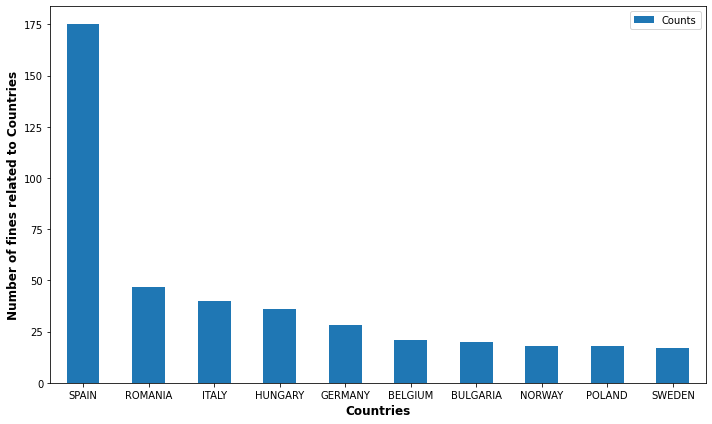

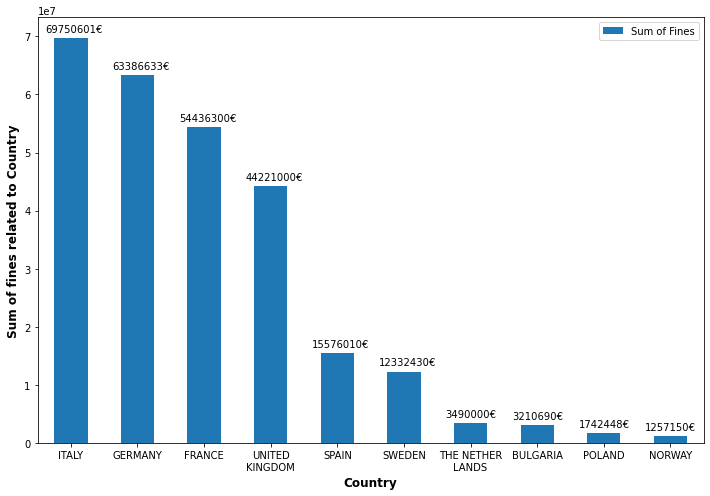

In [16]:
top10countries(DATA, "top10_countries")

# Quoted Article Related

In [17]:
def top10_quoted(data, fig_name):
    # Finding Top 5 Quoted Articles
    qd_list = data['Quoted Art.'].to_list()
    data_header = ['Quoted Art.']
    qa_list = []
    qa_count = []
    for q in qd_list:
        q = q.replace(",\r\n", ", ")
        q = q.replace(",\n", ", ")
        q = q.replace(" (", "(")
        a = q.rsplit(", ")
        for k in a:
            qa_list.append(k)
    qa_ds = pd.Series(qa_list).value_counts()

    tuple_list = qa_ds.index.tolist()
    indlist = []
    for i in tuple_list:
        indlist.append(''.join(i))
    ct_list = qa_ds.tolist()
    quoted_data = pd.DataFrame(data=indlist, columns=data_header)
    quoted_data['Counts'] = ct_list
    top10_quotedart = quoted_data.head(5)

    # Exporting the Top 10 Quoted Articles Plot
    top10_quotedart.loc[:, 'Quoted Art.'] = top10_quotedart.loc[:, 'Quoted Art.'].str.wrap(10)
    top10_quotedart.plot(figsize=(10, 6), x='Quoted Art.', y='Counts', kind='barh', rot=0)
    plt.ylabel('Quoted Articles', fontsize='large', fontweight='bold')
    plt.xlabel('Number of fines related to Articles', fontsize='large', fontweight='bold')
    plt.tight_layout();
    plt.savefig("../report_build/graphs/" + fig_name + ".jpeg")

    # Finding Top 10 Quoted Articles / Sum of fines
    qa_sum_fine = []
    for qa in quoted_data['Quoted Art.']:
        ex = data.loc[data['Quoted Art.'] == qa, :]
        ex = ex.reset_index()
        ex = ex[["Fine"]]
        ex.columns = ['Fine']

        ind = 0
        for fine in ex['Fine']:
            if (fine == "Unknown"):
                ex = ex.drop(ind, axis=0)
            ind = ind + 1
        sumfine = 0
        for fine in ex['Fine']:
            fine = int(str(fine).replace(',', ''))
            sumfine = sumfine + fine
        ex.reset_index()
        qa_sum_fine.append(sumfine)

    sumoffines_per_qa = {'Quoted Art.': quoted_data["Quoted Art."], 'Sum of Fines': qa_sum_fine}
    sumoffines_per_qa = pd.DataFrame(sumoffines_per_qa)
    sumoffines_per_qa.reset_index()
    sumoffines_per_qa.columns = ['Quoted Art.', 'Sum of Fines']

    # Exporting the Top 10 Quoted Articles / Sum of fines
    sumoffines_per_qa = sumoffines_per_qa.sort_values("Sum of Fines", ascending=False)
    top10_sumoffines_per_qa = sumoffines_per_qa.head(5)

    top10_sumoffines_per_qa.loc[:, 'Quoted Art.'] = top10_sumoffines_per_qa.loc[:, 'Quoted Art.'].str.wrap(10)

    # Plot
    ax = top10_sumoffines_per_qa.plot(figsize=(10, 6), x='Quoted Art.', y='Sum of Fines', kind='bar', rot=0)
    # set individual bar labels using above list
    # for i in ax.patches:
    #    # get_x pulls left or right; get_height pushes up or down
    #    ax.text(i.get_x()-0.13, i.get_height()+1000000,
    #            str(round((i.get_height()), 2))+"€", fontsize=10)
    plt.ylabel('Quoted Art.', fontsize='large', fontweight='bold')
    plt.xlabel('Sum of fines related to Quoted Art.', fontsize='large', fontweight='bold')
    plt.tight_layout();
    plt.savefig("../report_build/graphs/" + fig_name + "_fines.jpeg")

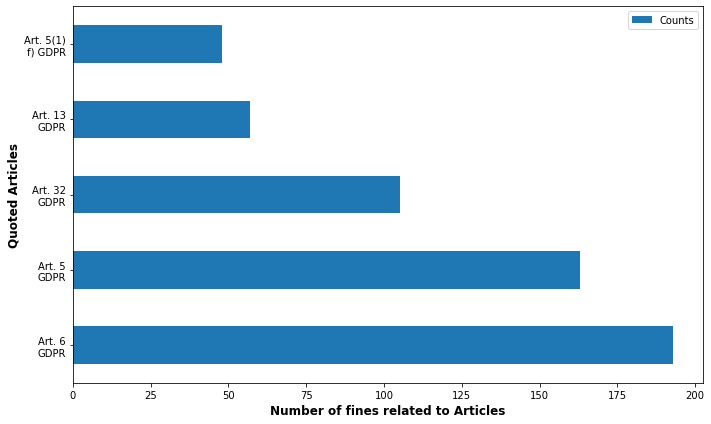

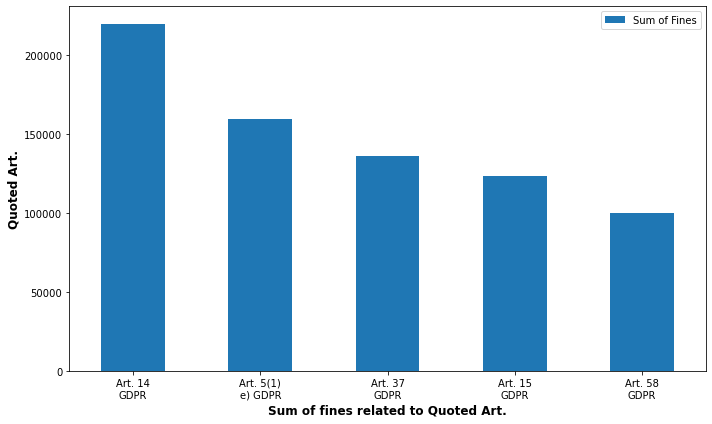

In [18]:
top10_quoted(DATA, "top10_quoted")

# Years Month Related 

In [19]:
def years_stat(data, fig_name):
    ### Number of fines according to the month
    # General Definition for all date related statistic
    date_list = []
    date_header = ['Year', 'Month', 'Day']
    month = ['', 'Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

    # Parse date into columns
    for d in data['Date']:
        date_list.append(d.split('-'))
    ds = pd.DataFrame(data=date_list, columns=date_header)

    # Get min & max of year & month
    da = ds.sort_values(['Year', 'Month'], na_position='first').dropna().reset_index().drop(columns='index')
    minyear = da['Year'][0]
    minmonth = da['Month'][0]
    maxyear = da['Year'][len(da) - 1]
    maxmonth = da['Month'][len(da) - 1]

    # Build xticks list & count for each ayear and month
    xtlist = []
    count = []
    for y in range(int(minyear), int(maxyear) + 1):
        for m in range(1, 13):
            if (((y == int(minyear)) & (m < int(minmonth))) | ((y == int(maxyear)) & (m > int(maxmonth)))):
                continue
            else:
                xtlist.append(str(y) + "  " + month[m])
                if (m < 10):
                    count.append(len(da[(da['Year'] == str(y)) & (da['Month'] == '0' + str(m))]))
                else:
                    count.append(len(da[(da['Year'] == str(y)) & (da['Month'] == str(m))]))

    # Prepare data frame for the graph
    dc = pd.DataFrame(data=xtlist, columns=['Year,Month'])
    dc['Count'] = count

    # Plot graph
    dc.plot(figsize=(12, 5), fontsize=10, color='blue', marker='o', legend=True, rot=60, ylim=(0, dc['Count'].max()))

    # Prepare Graph
    plt.xlabel("Year, Month", fontsize='large', fontweight='bold')
    plt.ylabel("Number of cases", fontsize='large', fontweight='bold')
    plt.xticks(range(0, len(xtlist)), xtlist)
    plt.yticks(list(range(0, dc['Count'].max() + 5, 5)))
    plt.title("Number of cases per month", fontsize='xx-large', fontweight='bold')

    # To specify the number of ticks on both or any single axes
    plt.locator_params(axis='x', nbins=(int(maxyear) - int(minyear)+1) * 6)
    plt.tight_layout()
    plt.grid()
    # plt.show()
    plt.savefig("../report_build/graphs/" + fig_name + "_graph.jpeg")


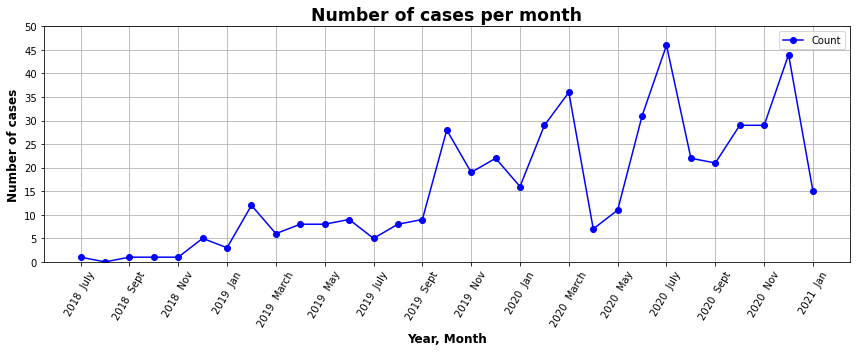

In [20]:

    years_stat(DATA, "NbFinesPerMonth")

# Overall Year

In [21]:

def year_by_year_fines():
    ### Number of fines according to the month
    # General Definition for all date related statistic
    date_list = []
    date_header = ['Year', 'Month', 'Day']
    month = ['', 'Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

    # Parse date into columns
    for d in DATA['Date']:
        date_list.append(d.split('-'))
    ds = pd.DataFrame(data=date_list, columns=date_header)

    # Get min & max of year & month
    da = ds.sort_values(['Year', 'Month'], na_position='first').dropna().reset_index().drop(columns='index')
    minyear = max(2018, YEAR - 10)
    minmonth = da['Month'][0]
    maxyear = da['Year'][len(da) - 1]
    maxmonth = da['Month'][len(da) - 1]

    # Build xticks list & count for each ayear and month
    xtlist = []
    count = []
    for y in range(int(minyear), int(maxyear) + 1):
        for m in range(1, 13):
            if (((y == int(minyear)) & (m < int(minmonth))) | ((y == int(maxyear)) & (m > int(maxmonth)))):
                continue
            else:
                xtlist.append(str(y) + "  " + month[m])
                if (m < 10):
                    count.append(len(da[(da['Year'] == str(y)) & (da['Month'] == '0' + str(m))]))
                else:
                    count.append(len(da[(da['Year'] == str(y)) & (da['Month'] == str(m))]))

    # Parse date related fine into ds column
    fine_sum = []
    for c in DATA['Fine']:
        if (c == "Unknown"):
            c = "0"
        fine_sum.append(int(c.replace(',', '')))
    ds['Fine'] = fine_sum
    dk = ds.sort_values(['Year', 'Month'], na_position='first').dropna().reset_index().drop(columns='index')

    # Build x ticks list & count for each year and month
    xtlist = []
    sum_year = []
    for y in range(int(minyear), int(maxyear) + 1):
        xtlist.append(str(y))
        s = (dk[(dk['Year'] == str(y))]['Fine']).to_list()
        acc = sum(s)
        sum_year.append(acc)
        if y == YEAR:
            VARS["year_fines"] = acc

    # Prepare data frame for the graph
    dc = pd.DataFrame(data=xtlist, columns=['Year'])
    dc['Sum'] = sum_year

    # Put label on top of each bar
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(str(height) + " €",
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Plot graph
    x = np.arange(len(dc['Year']))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 8))
    rects1 = ax.bar(x, dc['Sum'], width, label=xtlist)
    autolabel(rects1)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Sum')
    ax.set_title('Accumulate fines per year', fontsize='xx-large', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(xtlist)
    ax.get_yaxis().set_visible(False)
    fig.tight_layout()
    plt.savefig("../report_build/graphs/SumOfFinesperYear.jpeg")

In [22]:
year_by_year_fines()

NameError: name 'YEAR' is not defined

# Sector Related 

In [75]:

from pygoogletranslation  import Translator
translator = Translator()

def sector_stats(data, fig_name):
    # Retrieving Sectors Overall Statistics
   
    sector_data = pd.DataFrame(data['Sector'].value_counts())
    
    sector_data = sector_data.reset_index()
    
    sector_data.columns = ['Sector', 'Counts']
    print(sector_data['Sector'].size)
    for i in range(10):
        if(sector_data['Sector'][i]=="Employers"):
            sector_data['Sector'][i]="Employées"
        else:
            sector_data['Sector'][i] = translator.translate(str(sector_data['Sector'][i]),src='en', dest='fr').text
        print(sector_data['Sector'][i])

    # Exporting Sectors Overall Statistics Plot
    sector_data['Sector'] = sector_data['Sector'].str.wrap(18)
    sector_data.plot(figsize=(9, 6), y='Counts', kind='pie', labels=None, autopct='%1.0f%%', pctdistance=1.1)
    plt.legend(labels=sector_data['Sector'], fontsize='large', loc="upper right", bbox_to_anchor=(1.5, 1.2), ncol=1)
    plt.ylabel('')
    plt.xlabel('')
    plt.title('Sectors Overall Statistics', fontsize='large', fontweight='bold')
    plt.tight_layout()
    plt.savefig("../report_build/graphs/" + fig_name+".jpeg")

    # Finding Top 10 Quoted Articles / Sum of fines
    sector_data = pd.DataFrame(data['Sector'].value_counts())
    sector_data = sector_data.reset_index()
    sector_data.columns = ['Sector', 'Counts']
    sec_sum_fine = []

    for sec in sector_data['Sector']:
        ex = data.loc[data['Sector'] == sec, :]
        ex = ex.reset_index()
        ex = ex[["Fine"]]
        ex.columns = ['Fine']

        ind = 0
        for fine in ex['Fine']:
            if (fine == "Unknown"):
                ex = ex.drop(ind, axis=0)
            ind = ind + 1
        sumfine = 0
        for fine in ex['Fine']:
            fine = int(str(fine).replace(',', ''))
            sumfine = sumfine + fine
        ex.reset_index()
        sec_sum_fine.append(sumfine)

    sumoffines_per_sec = {'Sector': sector_data["Sector"], 'Sum of Fines': sec_sum_fine}
    sumoffines_per_sec = pd.DataFrame(sumoffines_per_sec)
    sumoffines_per_sec.reset_index()
    sumoffines_per_sec.columns = ['Sector', 'Sum of Fines (€)']

    # Exporting Sectors Overall Statistics Plot

    # Plot a background
    plt.figure(linewidth=3,
               edgecolor='steelblue',
               facecolor='skyblue',
               tight_layout={'pad': 1},
               figsize=(7, len(sumoffines_per_sec) / 2)
               )

    # Plot table
    the_table = plt.table(sumoffines_per_sec.values, colLabels=sumoffines_per_sec.columns, loc='center',
                          rowLoc='center', cellLoc='center')
    the_table.scale(1, 2)

    # Hide axes & Prepare graph
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.box(on=None)

    # Add title
    plt.title('Overall sum of fines per sector', y=1, fontsize='x-large', fontweight='bold')

    # Add footer
    # plt.figtext(0.95, 0.02, datetime.datetime.now(), horizontalalignment='right', size=8, weight='light')
    plt.savefig("../report_build/graphs/" + fig_name + "_fines.jpeg")

11
Médias, télécommunications et radiodiffusion


<ipython-input-75-2f43349dde0c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_data['Sector'][i] = translator.translate(str(sector_data['Sector'][i]),src='en', dest='fr').text


Industrie et commerce
Secteur public et éducation
Finance, assurance et conseil
Employées
Soins de santé


<ipython-input-75-2f43349dde0c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_data['Sector'][i]="Employées"


Non attribué
Transport et énergie
Particuliers et associations privées
Immobilier


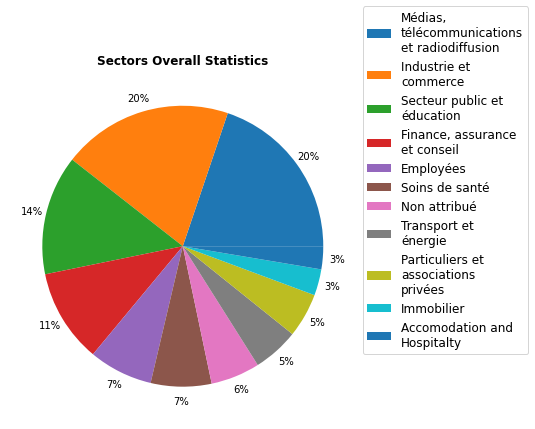

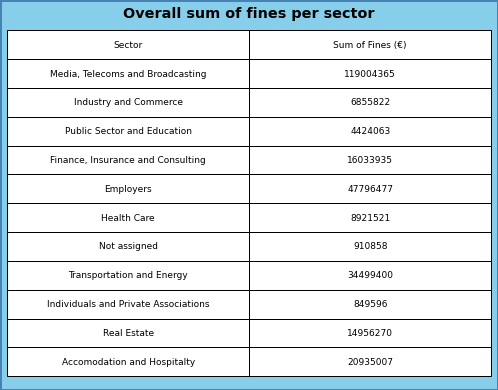

In [76]:
sector_stats(DATA, "sector_data")

# Controller Related 

In [180]:
def top10controller(data, fig_name):
    # Finding Top 10 Controller / Number of fines
    controller_data = pd.DataFrame(data['Controller'].value_counts())
    controller_data = controller_data.reset_index()
    controller_data.columns = ['Controller', 'Counts']
    controller_data = controller_data.drop(index=controller_data[controller_data['Controller'] == "Unknown"].index)
    controller_data = controller_data.drop(
        index=controller_data[controller_data['Controller'] == "Unknown Company"].index)
    controller_data = controller_data.drop(
        index=controller_data[controller_data['Controller'] == "Private Individual"].index)
    controller_data = controller_data.drop(
        index=controller_data[controller_data['Controller'] == "Private person"].index)
    controller_data = controller_data.drop(
        index=controller_data[controller_data['Controller'] == "Private Person"].index)
    controller_data = controller_data.drop(index=controller_data[controller_data['Controller'] == "Employer"].index)
    controller_data = controller_data.reset_index().drop(columns='index')
    top10_controller = controller_data.head(10)

    # Exporting the Top 10 Controller
    top10_controller['Controller'] = top10_controller['Controller'].str.wrap(10)
    top10_controller.plot(figsize=(11, 5), x='Controller', y='Counts', kind='bar', rot=0)
    plt.xlabel('Controller', fontsize='medium', fontweight='bold')
    plt.ylabel('Number of fines related to Controller', fontsize='large', fontweight='bold')
    plt.tight_layout();
    plt.savefig("../report_build/graphs/" + fig_name + ".jpeg")

    # Finding Top 10 Controller / Sum of fines
    controller_per_fine = pd.DataFrame(columns=['Controller', 'Sum of fines'])
    controller_sum_fine = []
    for controller in controller_data['Controller']:
        ex = data.loc[data['Controller'] == controller, :]
        ex = ex.reset_index()
        ex = ex[["Fine"]]
        ex.columns = ['Fine']

        ind = 0
        for fine in ex['Fine']:
            if (fine == "Unknown"):
                ex = ex.drop(ind, axis=0)
            ind = ind + 1
        sumfine = 0
        for fine in ex['Fine']:
            fine = int(str(fine).replace(',', ''))
            sumfine = sumfine + fine
        ex.reset_index()
        controller_sum_fine.append(sumfine)

    sumoffines_per_controller = {'Controller': controller_data["Controller"], 'Sum of Fines': controller_sum_fine}
    sumoffines_per_controller = pd.DataFrame(sumoffines_per_controller)
    sumoffines_per_controller.reset_index()
    sumoffines_per_controller.columns = ['Controller', 'Sum of Fines']

    # Exporting the Top 10 Controller / Sum of fines
    sumoffines_per_controller = sumoffines_per_controller.sort_values("Sum of Fines", ascending=False)
    top10_sumoffines_per_controller = sumoffines_per_controller.head(10)

    top10_sumoffines_per_controller['Controller'] = top10_sumoffines_per_controller['Controller'].str.wrap(10)
    ax = top10_sumoffines_per_controller.plot(figsize=(11, 7), x='Controller', y='Sum of Fines', kind='bar', rot=0)
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x() - 0.13, i.get_height() + 500000,
                str(round((i.get_height()), 2)) + "€", fontsize=10)
    plt.xlabel('Controller', fontsize='large', fontweight='bold')
    plt.ylabel('Sum of fines related to Controller', fontsize='large', fontweight='bold')
    plt.tight_layout();
    plt.savefig("../report_build/graphs/" + fig_name + "_fines.jpeg")


<ipython-input-180-226e735116fe>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_controller['Controller'] = top10_controller['Controller'].str.wrap(10)
<ipython-input-180-226e735116fe>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_sumoffines_per_controller['Controller'] = top10_sumoffines_per_controller['Controller'].str.wrap(10)


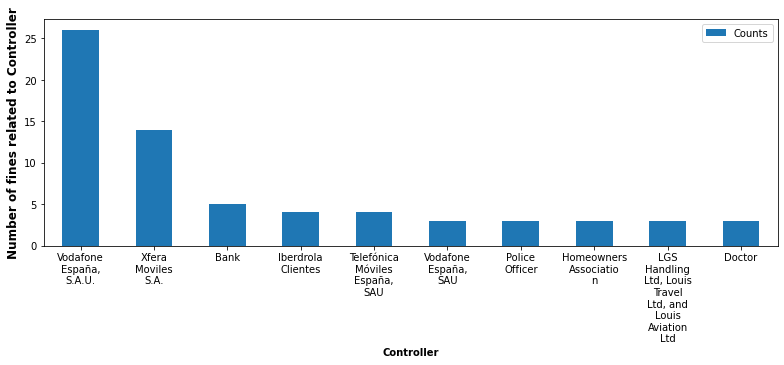

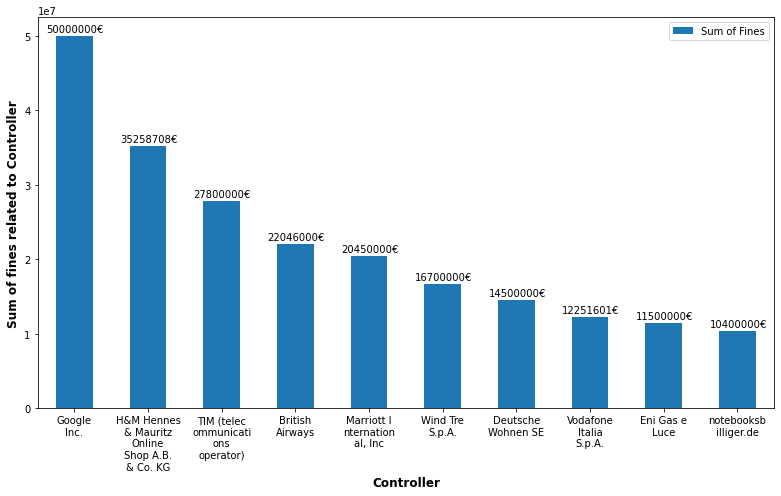

In [181]:
top10controller(DATA, "top10_controller")